In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
import glob
import gc
from gan_utils import *

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
ngpu = 1
nz = 32
ngf = 64
ndf = 64
nc = 3
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print('device:', device)

device: cuda:0


In [3]:
image_paths = sorted(glob.glob("segmentation/image64/*.jpg"))
image_paths = [path for path in image_paths if path.find('image_')<0]
realdata = flower_dataset(image_paths, 
                          transform=transforms.Compose(
                              [transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = DataLoader(realdata, batch_size=64, shuffle=True, num_workers=4)

100%|██████████| 25480/25480 [00:12<00:00, 2088.38it/s]


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f22786c5828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File

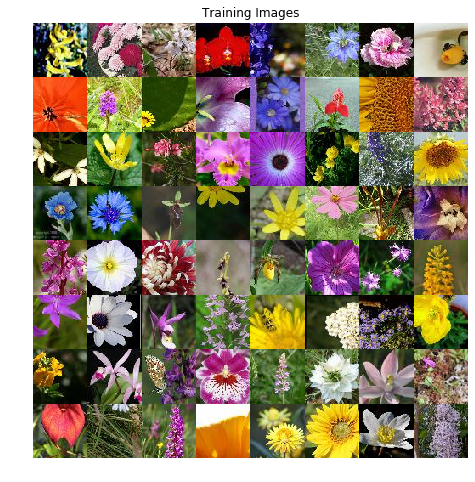

In [4]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [5]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
    
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)
print("netG parameters:", [p.numel() for p in netG.parameters() if p.requires_grad])

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(32, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
netG 

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            #in_channels, out_channels, kernel_size, stride=1, padding=0,
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print("netD parameters", [p.numel() for p in netD.parameters() if p.requires_grad])

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
netD parameters [3072, 131072, 128, 128, 524288, 2

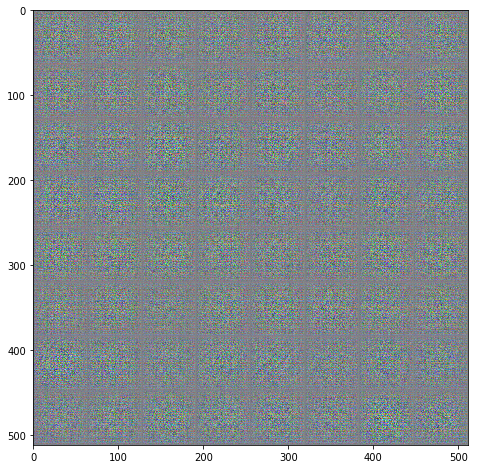

In [7]:
fixed_noise = torch.randn(64, nz, 2, 2, device=device)
fake_image = netG(fixed_noise)
output = netD(fake_image)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach(), padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [8]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

lr = 0.0002
beta1 = 0.5
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [9]:
!mkdir model_checkpoints
!mkdir sample_images
!mkdir sample_images/gan_z22

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 201
start_epoch = 0
n_update_G = 5

print("Starting Training Loop...")
# For each epoch
for epoch in range(start_epoch, start_epoch+num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        #real_cpu = data.to(device)
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        #label = get_label(b_size, real_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 2, 2, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #label = get_label(b_size, fake_label, soft=0.2, noise=True, noise_level=0.1, device=device)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        #print("output1",output[:5])
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        #label = get_label(b_size, real_label, soft=0.2, noise=False, device=device)
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 128 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f (%.4f / %.4f)  Loss_G: %.4f  D(x): %.4f  D(G(z)): %.4f / %.4f'
                  % (epoch, start_epoch+num_epochs, i, len(dataloader),
                     errD.item(), errD_real.item(), errD_fake.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            Ggradnorm_first = list(netG.parameters())[0].grad.norm()
            Ggradnorm_last = list(netG.parameters())[-1].grad.norm()
            print("Ggradnorm first: %.4f\t Ggradnormlast: %.4f"%(Ggradnorm_first, Ggradnorm_last))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == start_epoch+num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            image_tensor = vutils.make_grid(fake, padding=2, normalize=True)
            img_list.append(image_tensor)
            filepath = 'sample_images/gan_z22/ep'+str(epoch)+'_itr'+str(i)+'.jpg'
            io.imsave(filepath, image_tensor.numpy().transpose(1,2,0))

        iters += 1
        
    if epoch%20==0:
        checkpoint_path = "model_checkpoints/GAN_z22_ep"+str(epoch)
        print('save model to %s'%checkpoint_path)
        torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, checkpoint_path)
        
print('Done')

mkdir: cannot create directory ‘model_checkpoints’: File exists
mkdir: cannot create directory ‘sample_images’: File exists
mkdir: cannot create directory ‘sample_images/gan_z22’: File exists
Starting Training Loop...
[0/201][0/399]  Loss_D: 2.0908 (0.4413 / 1.6496)  Loss_G: 7.1935  D(x): 0.6773  D(G(z)): 0.7261 / 0.0017
Ggradnorm first: 17.1469	 Ggradnormlast: 25.2290


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[0/201][128/399]  Loss_D: 0.1318 (0.1200 / 0.0118)  Loss_G: 4.9703  D(x): 0.9164  D(G(z)): 0.0117 / 0.0110
Ggradnorm first: 4.3213	 Ggradnormlast: 61.8674
[0/201][256/399]  Loss_D: 0.1462 (0.0454 / 0.1008)  Loss_G: 5.1180  D(x): 0.9594  D(G(z)): 0.0815 / 0.0069
Ggradnorm first: 3.3065	 Ggradnormlast: 24.8827
[0/201][384/399]  Loss_D: 0.2262 (0.0735 / 0.1527)  Loss_G: 4.2706  D(x): 0.9350  D(G(z)): 0.1339 / 0.0187
Ggradnorm first: 3.5992	 Ggradnormlast: 20.2987
save model to model_checkpoints/GAN_z22_ep0
[1/201][0/399]  Loss_D: 0.3036 (0.2294 / 0.0742)  Loss_G: 4.4991  D(x): 0.8143  D(G(z)): 0.0613 / 0.0140
Ggradnorm first: 3.7146	 Ggradnormlast: 36.1815
[1/201][128/399]  Loss_D: 0.3476 (0.1118 / 0.2359)  Loss_G: 4.4154  D(x): 0.9030  D(G(z)): 0.1846 / 0.0172
Ggradnorm first: 6.1673	 Ggradnormlast: 26.7131
[1/201][256/399]  Loss_D: 0.2827 (0.1773 / 0.1054)  Loss_G: 4.5604  D(x): 0.8601  D(G(z)): 0.0955 / 0.0153
Ggradnorm first: 4.3679	 Ggradnormlast: 33.7784
[1/201][384/399]  Loss_D: 0.

[13/201][256/399]  Loss_D: 0.2074 (0.0352 / 0.1722)  Loss_G: 4.7127  D(x): 0.9661  D(G(z)): 0.1515 / 0.0117
Ggradnorm first: 8.1177	 Ggradnormlast: 24.1063
[13/201][384/399]  Loss_D: 0.3949 (0.1171 / 0.2778)  Loss_G: 5.2752  D(x): 0.9034  D(G(z)): 0.2075 / 0.0094
Ggradnorm first: 7.8737	 Ggradnormlast: 23.0523
[14/201][0/399]  Loss_D: 0.2017 (0.0451 / 0.1566)  Loss_G: 3.8842  D(x): 0.9576  D(G(z)): 0.1342 / 0.0312
Ggradnorm first: 8.5761	 Ggradnormlast: 35.2021
[14/201][128/399]  Loss_D: 0.7385 (0.0108 / 0.7278)  Loss_G: 6.8067  D(x): 0.9896  D(G(z)): 0.4404 / 0.0020
Ggradnorm first: 7.8910	 Ggradnormlast: 26.5947
[14/201][256/399]  Loss_D: 0.1648 (0.1414 / 0.0234)  Loss_G: 5.4909  D(x): 0.8825  D(G(z)): 0.0228 / 0.0069
Ggradnorm first: 7.8882	 Ggradnormlast: 19.4204
[14/201][384/399]  Loss_D: 0.7511 (0.7351 / 0.0160)  Loss_G: 1.4111  D(x): 0.5298  D(G(z)): 0.0157 / 0.3433
Ggradnorm first: 5.7583	 Ggradnormlast: 20.1595
[15/201][0/399]  Loss_D: 0.4178 (0.3755 / 0.0423)  Loss_G: 1.3326 

[26/201][384/399]  Loss_D: 0.4061 (0.0156 / 0.3905)  Loss_G: 3.4587  D(x): 0.9850  D(G(z)): 0.2857 / 0.0402
Ggradnorm first: 9.4939	 Ggradnormlast: 37.0116
[27/201][0/399]  Loss_D: 0.4111 (0.1024 / 0.3086)  Loss_G: 5.8240  D(x): 0.9135  D(G(z)): 0.2332 / 0.0043
Ggradnorm first: 10.7404	 Ggradnormlast: 35.8456
[27/201][128/399]  Loss_D: 0.0554 (0.0245 / 0.0310)  Loss_G: 4.7602  D(x): 0.9761  D(G(z)): 0.0296 / 0.0133
Ggradnorm first: 10.9714	 Ggradnormlast: 114.3973
[27/201][256/399]  Loss_D: 0.3964 (0.0416 / 0.3547)  Loss_G: 4.8816  D(x): 0.9600  D(G(z)): 0.2716 / 0.0099
Ggradnorm first: 10.8967	 Ggradnormlast: 24.1124
[27/201][384/399]  Loss_D: 0.2801 (0.0279 / 0.2522)  Loss_G: 4.3884  D(x): 0.9730  D(G(z)): 0.1896 / 0.0195
Ggradnorm first: 10.1114	 Ggradnormlast: 29.0833
[28/201][0/399]  Loss_D: 0.2652 (0.0375 / 0.2277)  Loss_G: 4.7571  D(x): 0.9680  D(G(z)): 0.1504 / 0.0150
Ggradnorm first: 10.7422	 Ggradnormlast: 52.5052
[28/201][128/399]  Loss_D: 0.1920 (0.0314 / 0.1606)  Loss_G: 5

[40/201][0/399]  Loss_D: 2.1318 (0.0012 / 2.1305)  Loss_G: 11.6776  D(x): 0.9988  D(G(z)): 0.7186 / 0.0001
Ggradnorm first: 10.2008	 Ggradnormlast: 45.2899
[40/201][128/399]  Loss_D: 0.2090 (0.0653 / 0.1437)  Loss_G: 3.5403  D(x): 0.9408  D(G(z)): 0.1219 / 0.0429
Ggradnorm first: 10.5848	 Ggradnormlast: 37.3069
[40/201][256/399]  Loss_D: 0.0988 (0.0899 / 0.0089)  Loss_G: 5.2334  D(x): 0.9207  D(G(z)): 0.0086 / 0.0138
Ggradnorm first: 12.0507	 Ggradnormlast: 39.6093
[40/201][384/399]  Loss_D: 0.0732 (0.0578 / 0.0155)  Loss_G: 5.1545  D(x): 0.9462  D(G(z)): 0.0143 / 0.0116
Ggradnorm first: 13.5040	 Ggradnormlast: 48.7233
save model to model_checkpoints/GAN_z22_ep40
[41/201][0/399]  Loss_D: 0.0527 (0.0490 / 0.0038)  Loss_G: 5.2748  D(x): 0.9534  D(G(z)): 0.0037 / 0.0080
Ggradnorm first: 13.3498	 Ggradnormlast: 72.8683
[41/201][128/399]  Loss_D: 0.0335 (0.0063 / 0.0272)  Loss_G: 5.1984  D(x): 0.9938  D(G(z)): 0.0262 / 0.0083
Ggradnorm first: 12.9322	 Ggradnormlast: 52.0074
[41/201][256/399

[53/201][128/399]  Loss_D: 0.1395 (0.0066 / 0.1328)  Loss_G: 5.9480  D(x): 0.9935  D(G(z)): 0.1087 / 0.0046
Ggradnorm first: 13.0423	 Ggradnormlast: 25.5595
[53/201][256/399]  Loss_D: 0.0462 (0.0374 / 0.0087)  Loss_G: 5.0422  D(x): 0.9643  D(G(z)): 0.0086 / 0.0113
Ggradnorm first: 13.8728	 Ggradnormlast: 52.1639
[53/201][384/399]  Loss_D: 0.0140 (0.0054 / 0.0086)  Loss_G: 6.0380  D(x): 0.9947  D(G(z)): 0.0085 / 0.0039
Ggradnorm first: 12.7588	 Ggradnormlast: 30.1367
[54/201][0/399]  Loss_D: 0.0174 (0.0034 / 0.0140)  Loss_G: 4.9415  D(x): 0.9966  D(G(z)): 0.0137 / 0.0159
Ggradnorm first: 15.2407	 Ggradnormlast: 79.0028
[54/201][128/399]  Loss_D: 0.0291 (0.0064 / 0.0227)  Loss_G: 5.1964  D(x): 0.9936  D(G(z)): 0.0221 / 0.0094
Ggradnorm first: 13.1413	 Ggradnormlast: 64.6537
[54/201][256/399]  Loss_D: 0.0206 (0.0067 / 0.0139)  Loss_G: 6.5551  D(x): 0.9934  D(G(z)): 0.0129 / 0.0034
Ggradnorm first: 14.8809	 Ggradnormlast: 30.9556
[54/201][384/399]  Loss_D: 0.1202 (0.1020 / 0.0182)  Loss_G:

[66/201][256/399]  Loss_D: 0.0122 (0.0043 / 0.0079)  Loss_G: 6.1271  D(x): 0.9957  D(G(z)): 0.0078 / 0.0045
Ggradnorm first: 12.7497	 Ggradnormlast: 38.0132
[66/201][384/399]  Loss_D: 0.0853 (0.0788 / 0.0065)  Loss_G: 2.7818  D(x): 0.9280  D(G(z)): 0.0065 / 0.0995
Ggradnorm first: 14.1279	 Ggradnormlast: 60.4699
[67/201][0/399]  Loss_D: 5.3130 (0.0006 / 5.3124)  Loss_G: 7.4961  D(x): 0.9994  D(G(z)): 0.9805 / 0.0022
Ggradnorm first: 7.9329	 Ggradnormlast: 13.3779
[67/201][128/399]  Loss_D: 0.0276 (0.0003 / 0.0272)  Loss_G: 5.3156  D(x): 0.9997  D(G(z)): 0.0265 / 0.0086
Ggradnorm first: 14.7059	 Ggradnormlast: 50.2408
[67/201][256/399]  Loss_D: 0.0602 (0.0110 / 0.0493)  Loss_G: 5.3178  D(x): 0.9892  D(G(z)): 0.0465 / 0.0087
Ggradnorm first: 12.8243	 Ggradnormlast: 27.8628
[67/201][384/399]  Loss_D: 0.0309 (0.0177 / 0.0132)  Loss_G: 7.1641  D(x): 0.9830  D(G(z)): 0.0129 / 0.0020
Ggradnorm first: 12.5926	 Ggradnormlast: 35.2436
[68/201][0/399]  Loss_D: 1.2071 (0.0003 / 1.2068)  Loss_G: 12

[79/201][384/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 39.2011  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0001	 Ggradnormlast: 0.0011
[80/201][0/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 39.2738  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0002	 Ggradnormlast: 0.0010
[80/201][128/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 38.9554  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0010	 Ggradnormlast: 0.0035
[80/201][256/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 38.6554  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0024	 Ggradnormlast: 0.0056
[80/201][384/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 38.5099  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0002	 Ggradnormlast: 0.0020
save model to model_checkpoints/GAN_z22_ep80
[81/201][0/399]  Loss_D: 0.0000 (0.0000 / 0.0000)  Loss_G: 38.6565  D(x): 1.0000  D(G(z)): 0.0000 / 0.0000
Ggradnorm first: 0.0003	 Ggradnormlast: 0.0024
[81/201][128/399]  Loss

Process Process-330:
Process Process-331:
Process Process-329:
Process Process-332:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_IN

KeyboardInterrupt: 

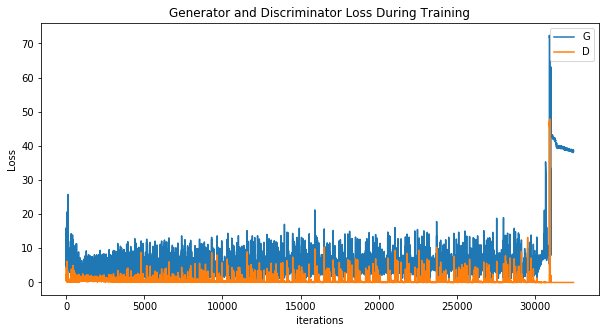

In [10]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
torch.save({
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            }, "model_checkpoints/GAN_z22")